In [1]:
import pandas as pd

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 

from sklearn.metrics import f1_score, make_scorer
import numpy as np

# отключение предупреждений
import warnings; warnings.filterwarnings("ignore", category=Warning)

In [3]:
from collections import Counter
import re
import pymorphy2

In [4]:
import nltk
#nltk.download('stopwords')

In [5]:
from nltk import word_tokenize
import nltk
#nltk.download('punkt')

In [6]:
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from catboost import CatBoostClassifie

# грузим сеты

In [7]:
# исходный сет 
train_short = pd.read_parquet('train_short')

# токенизированный сет + убрал дубликаты и пропуски
train_short_tokin = pd.read_parquet('train_short_token')
train_short_tokin.rename(columns={'tokenized_sents_text': 'item_name'}, inplace=True)

In [8]:
train_short

,item_name,category_id
0,"молоко 3,2%,шт",78
1,"компот из изюма, 114 ккал",71
2,"макаронные изделия отварные (масло сливочное),...",71
3,кофе капучино большой эден 18,70
4,хлеб на сыворотке 350г,84
...,...,...
47960,"напиток энерг. ред булл 0,355л",83
47961,хеменгуэй дайкири,0
47962,"пиво светлое ""халзан"" 4,5 % об, пл/б. 1,5 л(шт)",0
47963,экспресс педикюр,42


In [9]:
train_short_tokin

,category_id,item_name
0,78,молоко
1,71,компот изюма ккал
2,71,макаронные изделия отварные масло сливочное ккал
3,70,кофе капучино большой эден
4,84,хлеб сыворотке
...,...,...
43265,84,зефир шпек дульчия
43266,0,хеменгуэй дайкири
43267,0,пиво светлое халзан плб лшт
43268,42,экспресс педикюр


In [37]:
train_short_tokin.sample(5)

,category_id,item_name
33078,130,гавайи
29952,130,бутылка irontrue
35963,81,попкорн crazy zebra сладкий
34121,83,мин вода фрутоняня артезианс
4721,75,зеленый горошек


# ВЕКТОРИЗАЦИЯ

In [10]:
stop = stopwords.words('russian')

### TfidfVectorizer (train_short_origin)

**используется исходная таблица - нижний регистр, дубликаты**

In [11]:
tfidf_bl = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_bl = tfidf_bl.fit_transform(train_short.item_name)
y_train_bl = train_short['category_id']

In [12]:
print(X_train_bl.shape)

(47965, 37160)


## TfidfVectorizer (train_short) - только токинайзер

**используется таблица train_short + токинайзинг**

In [13]:
tfidf_tokin = TfidfVectorizer(stop_words=stop, max_features=100000)
X_train_tokin = tfidf_tokin.fit_transform(train_short_tokin.item_name)
y_train_tokin = train_short_tokin['category_id']

In [14]:
print(X_train_tokin.shape)

(43270, 37573)


## 4 Случайный лес (параметры по умолчанию)

In [15]:
clf_RF = RandomForestClassifier(class_weight='balanced', random_state=12345)

### 4.1 на оригинальном сете

In [16]:
%%time
scores_4_1 = cross_val_score(clf_RF, X_train_bl, y_train_bl, cv=3, scoring='f1_weighted')

CPU times: user 18min 29s, sys: 16.3 s, total: 18min 45s
Wall time: 19min 32s


In [17]:
np.mean(scores_4_1)

0.7404774552343675

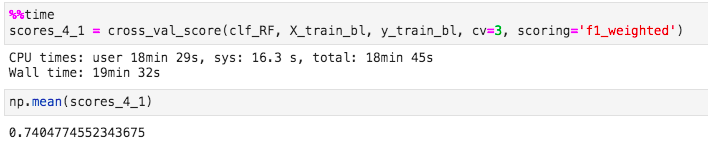

### 4.2 на токенизированном сете 

In [18]:
%%time
scores_4_2 = cross_val_score(clf_RF, X_train_tokin, y_train_tokin, cv=3, scoring='f1_weighted')

CPU times: user 18min 59s, sys: 16.5 s, total: 19min 15s
Wall time: 20min 22s


In [19]:
np.mean(scores_4_2)

0.7121207270151076

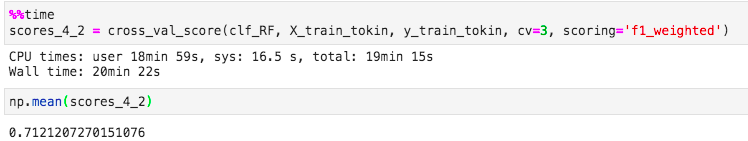

## 5 Решающее дерево (параметры по умолчанию)

In [20]:
clf_DT = DecisionTreeClassifier(class_weight='balanced', random_state=12345)

### 4.3 на оригинальном сете

In [21]:
%%time
scores_4_3 = cross_val_score(clf_DT, X_train_bl, y_train_bl, cv=3, scoring='f1_weighted')

CPU times: user 2min 14s, sys: 705 ms, total: 2min 14s
Wall time: 2min 27s


In [22]:
np.mean(scores_4_3)

0.6864707929900252

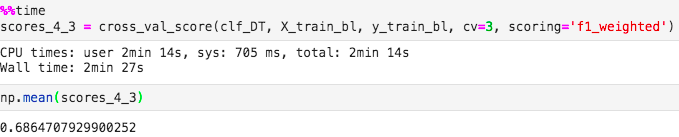

### 4.4 на токенизированном сете 

In [ ]:
scores_4_4 = cross_val_score(clf_DT, X_train_tokin, y_train_tokin, cv=8, scoring='f1_weighted')

In [ ]:
np.mean(scores_4_4)

### 4.4 на токенизированном сете 

In [23]:
%%time
scores_4_4 = cross_val_score(clf_DT, X_train_tokin, y_train_tokin, cv=3, scoring='f1_weighted')

CPU times: user 2min 14s, sys: 390 ms, total: 2min 15s
Wall time: 2min 15s


In [33]:
np.mean(scores_4_4)

0.6774625968667173

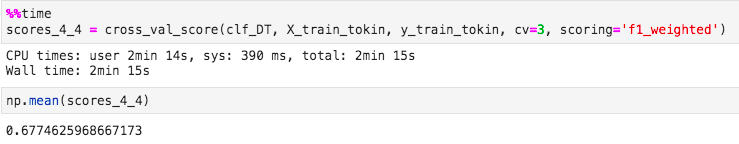

## 6 Ближайшие соседи (параметры по умолчанию)

In [25]:
clf_KNC = KNeighborsClassifier()

### 4.5 на оригинальном сете

In [26]:
%%time
scores_4_5 = cross_val_score(clf_KNC, X_train_bl, y_train_bl, cv=3, scoring='f1_weighted')

CPU times: user 34.4 s, sys: 24 s, total: 58.4 s
Wall time: 1min 3s


In [27]:
np.mean(scores_4_5)

0.3959484541572856

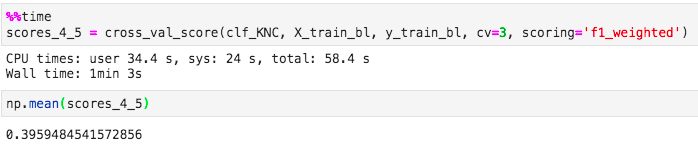

### 4.6 на токенизированном сете 

In [28]:
%%time
scores_4_6 = cross_val_score(clf_KNC, X_train_tokin, y_train_tokin, cv=3, scoring='f1_weighted')

CPU times: user 27.3 s, sys: 18.8 s, total: 46.1 s
Wall time: 49.2 s


In [29]:
np.mean(scores_4_6)

0.5638394624322937

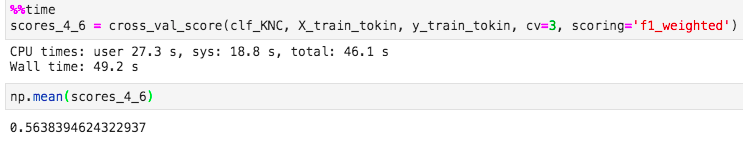

## 7 GradientBoostingClassifier (параметры по умолчанию)

In [30]:
clf_GBC = GradientBoostingClassifier(random_state=12345)

### 4.7 на оригинальном сете

In [34]:
# %%time
# scores_4_7 = cross_val_score(clf_GBC, X_train_bl, y_train_bl, cv=3, scoring='f1_weighted')

In [36]:
# np.mean(scores_4_7)

### 4.8 на токенизированном сете 

In [ ]:
%%time
scores_4_8 = cross_val_score(clf_GBC, X_train_tokin, y_train_tokin, cv=3, scoring='f1_weighted')

In [ ]:
np.mean(scores_4_8)

# РЕЗУЛЬТАТЫ  - только история

# LogisticRegression

**1.1_
TfidfVectorizer (unique)**

In [ ]:
# %%time
# clf_1_2 = LogisticRegression(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_unique, y_train_unique, cv=3, scoring='f1_weighted')

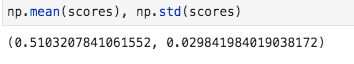

**1_2 расчет baseline - TfidfVectorizer (train_short_origin) - исходный сет**

In [ ]:
# %%time
# clf_1_2 = LogisticRegression(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_bl, y_train_bl, cv=3, scoring='f1_weighted')

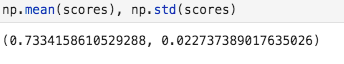

**1_3 TfidfVectorizer (train_short)**

In [ ]:
# %%time
# clf_1_3 = LogisticRegression(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_clean, y_train_clean, cv=3, scoring='f1_weighted')

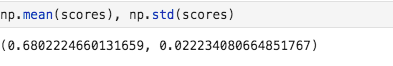

# LinearSVC

**2_1 TfidfVectorizer (unique)**

In [ ]:
# %%time
# clf = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_unique, y_train_unique, cv=8, scoring='f1_weighted')

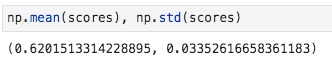

**2_2 расчет baseline - TfidfVectorizer (train_short_origin) - исходный сет**

In [ ]:
# %%time
# clf_2_2 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_bl, y_train_bl, cv=8, scoring='f1_weighted')

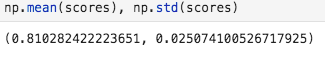

**2_3 TfidfVectorizer (train_short)**

In [ ]:
# %%time
# clf_2_3 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_clean, y_train_clean, cv=8, scoring='f1_weighted')

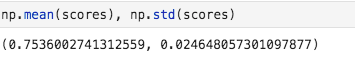

# LinearSVC

**3_1 TfidfVectorizer (train_short) - только токинайзинг - нормальные формы слов не извлекались**

In [ ]:
# %%time
# clf_3_1 = LinearSVC(max_iter=400, class_weight='balanced', random_state=12345)
# scores = cross_val_score(clf, X_train_tokin, y_train_tokin, cv=8, scoring='f1_weighted')

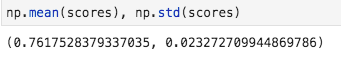